In [55]:
from math import cos, sin, asin, acos, gcd, atan2
import numpy as np
from numpy import array, dot, degrees, cross
from numpy.linalg import inv, det, solve, norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# import the python scripts:
import csl_generator as csl
import gb_generator as gbc

%matplotlib notebook

## Produce Lists of CSL boundaries for any given rotation axis (hkl) :



In [2]:
# for example: [1, 0, 0], [1, 1, 0] or [1, 1, 1]
axis = np.array([1, 1, 1])

# list Sigma boundaries < 50
csl.print_list(axis,50)


Sigma:     1  Theta:   0.00 
Sigma:     3  Theta:  60.00 
Sigma:     7  Theta:  38.21 
Sigma:    13  Theta:  27.80 
Sigma:    19  Theta:  46.83 
Sigma:    21  Theta:  21.79 
Sigma:    31  Theta:  17.90 
Sigma:    37  Theta:  50.57 
Sigma:    39  Theta:  32.20 
Sigma:    43  Theta:  15.18 
Sigma:    49  Theta:  43.57 


## Select a sigma and get the characteristics of the GB:

In [33]:
# pick a sigma for this axis, ex: 19.
sigma = 13

theta, m, n = csl.get_theta_m_n_list(axis,sigma)[0]

R = csl.rot(axis, theta)

# Minimal CSL cells. The plane orientations and the orthogonal cells
# will be produced from these original cells.
M1, M2 = csl.Create_minimal_cell_Method_1(sigma,axis,R)


print('Angle:',degrees(theta),'\n','Sigma:',sigma,'\n', 'Minimal cells:','\n', M1,'\n',M2,'\n', )

Angle: 27.79577249602797 
 Sigma: 13 
 Minimal cells: 
 [[ 1 -2  1]
 [-2 -1  1]
 [ 2  2  1]] 
 [[ 2 -1  1]
 [-2 -2  1]
 [ 1  2  1]] 



## Produce Lists of GB planes for the chosen boundary :


In [35]:
# the higher the limit the higher the indices of GB planes produced.
lim = 5

V1, V2, M, Gb = csl.Create_Possible_GB_Plane_List(axis, m,n,lim)

df = pd.DataFrame(
    {'GB1': list(V1),
     'GB2': list(V2),
     'Type': Gb
    })

df.head()

,GB1,GB2,Type
0,"[2, 1, -2]","[1, 2, -2]",Mixed
1,"[-1, -1, -1]","[-1, -1, -1]",Twist
2,"[1, 1, 1]","[1, 1, 1]",Twist
3,"[-1, 2, -2]","[-2, 2, -1]",Mixed
4,"[-2, -1, 2]","[-1, -2, 2]",Mixed


## Criteria for finding the GB plane of interest*: 

###  1- Based on the type of GB plane: 

#### _* The following criteria searches the generated data frame. To extend the search you can increase the limit (lim)_
#### _in the above cell._

In [36]:
# Gb types: Symmetric Tilt, Tilt, Twist, Mixed

df[df['Type'] == 'Symmetric Tilt'].head()

,GB1,GB2,Type
13,"[-1, -3, 4]","[1, -4, 3]",Symmetric Tilt
15,"[1, 3, -4]","[-1, 4, -3]",Symmetric Tilt
64,"[-3, 4, -1]","[-4, 3, 1]",Symmetric Tilt
69,"[-4, 1, 3]","[-3, -1, 4]",Symmetric Tilt
71,"[3, -4, 1]","[4, -3, -1]",Symmetric Tilt



### 2 - Based on the minimum number of atoms in the orthogonal cell:
####  _This can be of interest for DFT calculations that require smaller cells. The search may take a few minutes if your original limit_
#### _is large as it must calculate all the orthogonal cells to know the number of atoms._


In [37]:
basis = 'fcc'
Number = np.zeros(len(V1))
Number_atoms = []
for i in range((len(V1))):
    Number_atoms.append(csl.Find_Orthogonal_cell(basis,axis,m,n,V1[i])[2])

In [41]:
# show me Gb planes that have orthogonal cells with less than max_num_atoms, here: 500. 

df['Number'] = Number_atoms  

max_num_atoms = 300
df[df['Number'] < max_num_atoms]

,GB1,GB2,Type,Number,Angles
1,"[-1, -1, -1]","[-1, -1, -1]",Twist,156,90.000000
2,"[1, 1, 1]","[1, 1, 1]",Twist,156,90.000000
6,"[0, -3, 1]","[1, -3, 0]",Mixed,260,36.271199
9,"[-1, 0, 3]","[0, -1, 3]",Mixed,260,36.271199
11,"[0, 3, -1]","[-1, 3, 0]",Mixed,260,36.271199
13,"[-1, -3, 4]","[1, -4, 3]",Symmetric Tilt,156,0.000000
14,"[1, 0, -3]","[0, 1, -3]",Mixed,260,36.271199
15,"[1, 3, -4]","[-1, 4, -3]",Symmetric Tilt,156,0.000000
16,"[-3, 1, 0]","[-3, 0, 1]",Mixed,260,36.271199
17,"[3, -1, 0]","[3, 0, -1]",Mixed,260,36.271199


### 3- Based on proximity to a particular type boundary, for example the Symmetric tilts:
####  _This is how I created various steps on grain boundaries with vicinal orientations in the following work:_
#### __(https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.043601)__
#### _See also here:_
__(https://www.mpie.de/2955247/GrainBoundaryDynamics)__

In [44]:
SymmTiltGbs = []
for i in range(len(V1)):
    if str(Gb[i]) == 'Symmetric Tilt':
        SymmTiltGbs.append(V1[i])

# Find GBs less than Delta (here 4) degrees from any of the symmetric tilt boundaries in this system

Delta = 4
Min_angles = []
for i in range(len(V1)):
    angles = []
    for j in range(len(SymmTiltGbs)):
        angles.append(csl.angv(V1[i],SymmTiltGbs[j]))
    Min_angles.append(min(angles))    


In [43]:
df['Angles'] = Min_angles

df[df['Angles'] < Delta]

,GB1,GB2,Type,Number,Angles
13,"[-1, -3, 4]","[1, -4, 3]",Symmetric Tilt,156,0.000000
15,"[1, 3, -4]","[-1, 4, -3]",Symmetric Tilt,156,0.000000
64,"[-3, 4, -1]","[-4, 3, 1]",Symmetric Tilt,468,0.000000
69,"[-4, 1, 3]","[-3, -1, 4]",Symmetric Tilt,468,0.000000
71,"[3, -4, 1]","[4, -3, -1]",Symmetric Tilt,468,0.000000
73,"[4, -1, -3]","[3, 1, -4]",Symmetric Tilt,468,0.000000
629,"[-3, -11, 17]","[5, -15, 13]",Mixed,65364,4.853954
651,"[3, 11, -17]","[-5, 15, -13]",Mixed,65364,4.853954
653,"[5, 13, -15]","[-3, 17, -11]",Mixed,65364,4.853954
664,"[-5, -13, 15]","[3, -17, 11]",Mixed,65364,4.853954


## Select a GB plane and go on:
### You only need to pick the GB1 plane, from any of the three criteria in the cells above

In [59]:
GB_plane = [-7, 5, 2]
# lattice parameter
LatP = 4
basis = 'fcc'

In [60]:
# just a piece of info, how much of this mixed boundary is tilt or twist?
csl.Tilt_Twist_comp(GB_plane, axis, m, n)

Pure tilt boundary with a tilt component:  27.80


In [65]:
# instantiate a GB:
my_gb = gbc.GB_character()

# give all the characteristics
my_gb.ParseGB (axis, basis, LatP, m, n, GB_plane)

# Create the bicrystal
my_gb.CSL_Bicrystal_Atom_generator()

# Write a GB :
# by default overlap = 0.0, rigid = False, 
#           dim1, dim2, dim3 = [1, 1, 1]
#           file = 'LAMMPS'
# read the io_file and README for more info, briefly: when you give overlap > 0
# you need to decide 'whichG': atoms to be removed from either G1 or G2.
# if rigid = True, then you need two integers a and b to make a mesh on the GB
# a and b can be put to 10 and 5 (just a suggestion) respectively for any GB except
# TWIST for the TWISTS the code will handle it internally regardless of your input a and b
# ex:
#my_gb.WriteGB(overlap= 0.3, whichG= 'g1', rigid= True,a = 3, b= 2, dim2=5 , file='VASP')

my_gb.WriteGB(overlap=0.3, whichG='g1', dim1=3, dim2=3, dim3= 2,file='VASP')

<<------ 0 atoms are being removed! ------>>
<<------ 1 GB structure is being created! ------>>


In [66]:
## extract atom positions of the two grains:

X = my_gb.atoms1
Y = my_gb.atoms2

In [63]:
# 3d plot of the gb, that can be shown in any cartesian view direction:

def plot_gb(X,Y, view_dir = [0,1,0]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2],'o', s = 20, facecolor = 'y',edgecolor='none', alpha=0.2 )
    ax.scatter(Y[:,0],Y[:,1],Y[:,2],'o',s = 20,facecolor = 'b',edgecolor='none', alpha=0.2)
    
    # Show [0, 0, 0] as a red point
    ax.scatter(0,0,0,'s',s = 200,facecolor = 'r',edgecolor='none')
    ax.set_proj_type('ortho')
    ax.grid(False)
    az = degrees(atan2(view_dir[1],view_dir[0]))
    el = degrees(asin(view_dir[2]/norm(view_dir)))
    ax.view_init(azim = az, elev = el)       
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    return            


<IPython.core.display.Javascript object>


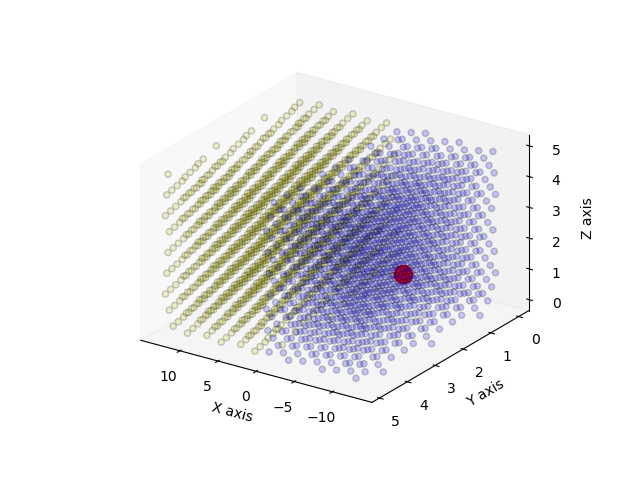

In [67]:
%matplotlib notebook
plot_gb(X,Y,[0,1,0])